Import needed stuff

In [1]:
import requests
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
from matplotlib import pyplot as plt
import seaborn as sns
import networkscience as ns
import pycountry as pc

Downloading data by http request

In [2]:
reply = requests.get('https://data.europa.eu/euodp/data/storage/f/2020-08-11T140550/Finalised%20mobilities%20started%20in%202018%20-%20KA1.csv')
reply.encoding = 'utf-8'
csv_data = reply.text
df = pd.read_csv(StringIO(csv_data), sep=';',low_memory=False)

## Mobility of Countries
In this section we want to analyze how musch different countries are involved in the Erasmus program.

I am not sure there are enought node to have a sensible analysis of the problem.

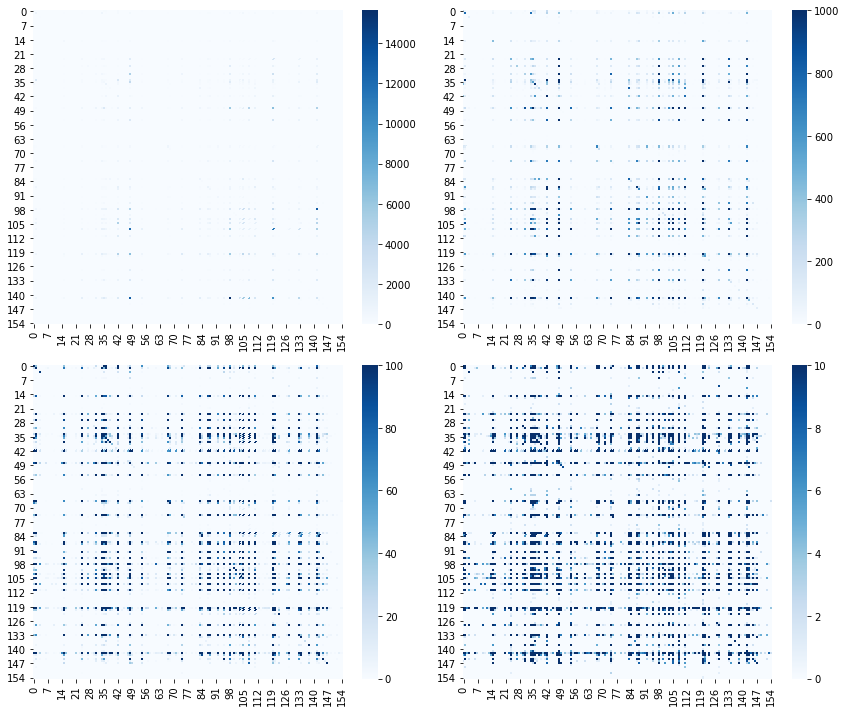

In [3]:
country_df = df[df[df.columns[10]]=='Learner']
country_df = country_df.loc[:, df.columns[np.array((14, 17, 20))]]
country_df.dropna(how='any', inplace=True)
nodes = np.array(list(set.union(set(country_df.loc[:, country_df.columns[0]]), set(country_df.loc[:, country_df.columns[1]]))))
# I don't want it to take forever
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
country_df['SendId'] = (np.array(list(map(lambda x: node_position[x], country_df['Sending Country Code']))))
country_df['RecId']= (np.array(list(map(lambda x: node_position[x], country_df['Receiving Country Code']))))
# Adjacency matrix
country_serie = country_df.groupby(['SendId', 'RecId']).sum()
row = np.array(country_serie.index.get_level_values(1).tolist())
col = np.array(country_serie.index.get_level_values(0).tolist())
val = country_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

def replace_iso3166(alpha):
    try:
        return pc.countries.get(alpha_2=alpha).name
    except:
        return alpha

country_df['Receiving Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), country_df['Receiving Country Code']))))
country_df['Sending Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), country_df['Sending Country Code']))))
nodes_df['Nodes'] = (np.array(list(map(lambda x: replace_iso3166(x), nodes_df['Nodes']))))

ns.visualize_adj(adj_matrix_crs)

I would like to understand if the corresponent undirected unwiegthed graph was symmetric, but it is not

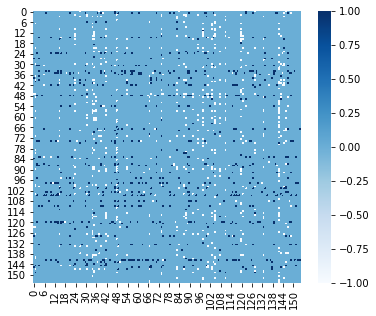

In [4]:
matr = adj_matrix_crs.toarray()
matr[matr>1]=1
matr = matr - matr.T
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(matr, cmap="Blues", ax=ax)
plt.show()


Calculation of the number of components in the network

In [5]:
country_df.rename({'Sending Country Code': 'source', 'Receiving Country Code':'target', 'Participants':'weight'},axis=1, inplace=True)
components = ns.find_components(adj_matrix_crs, nodes_df)
unique, counts = np.unique(components['component'], return_counts=True)
print('Number of components =', len(unique))

Number of components = 1


### Degree distribution

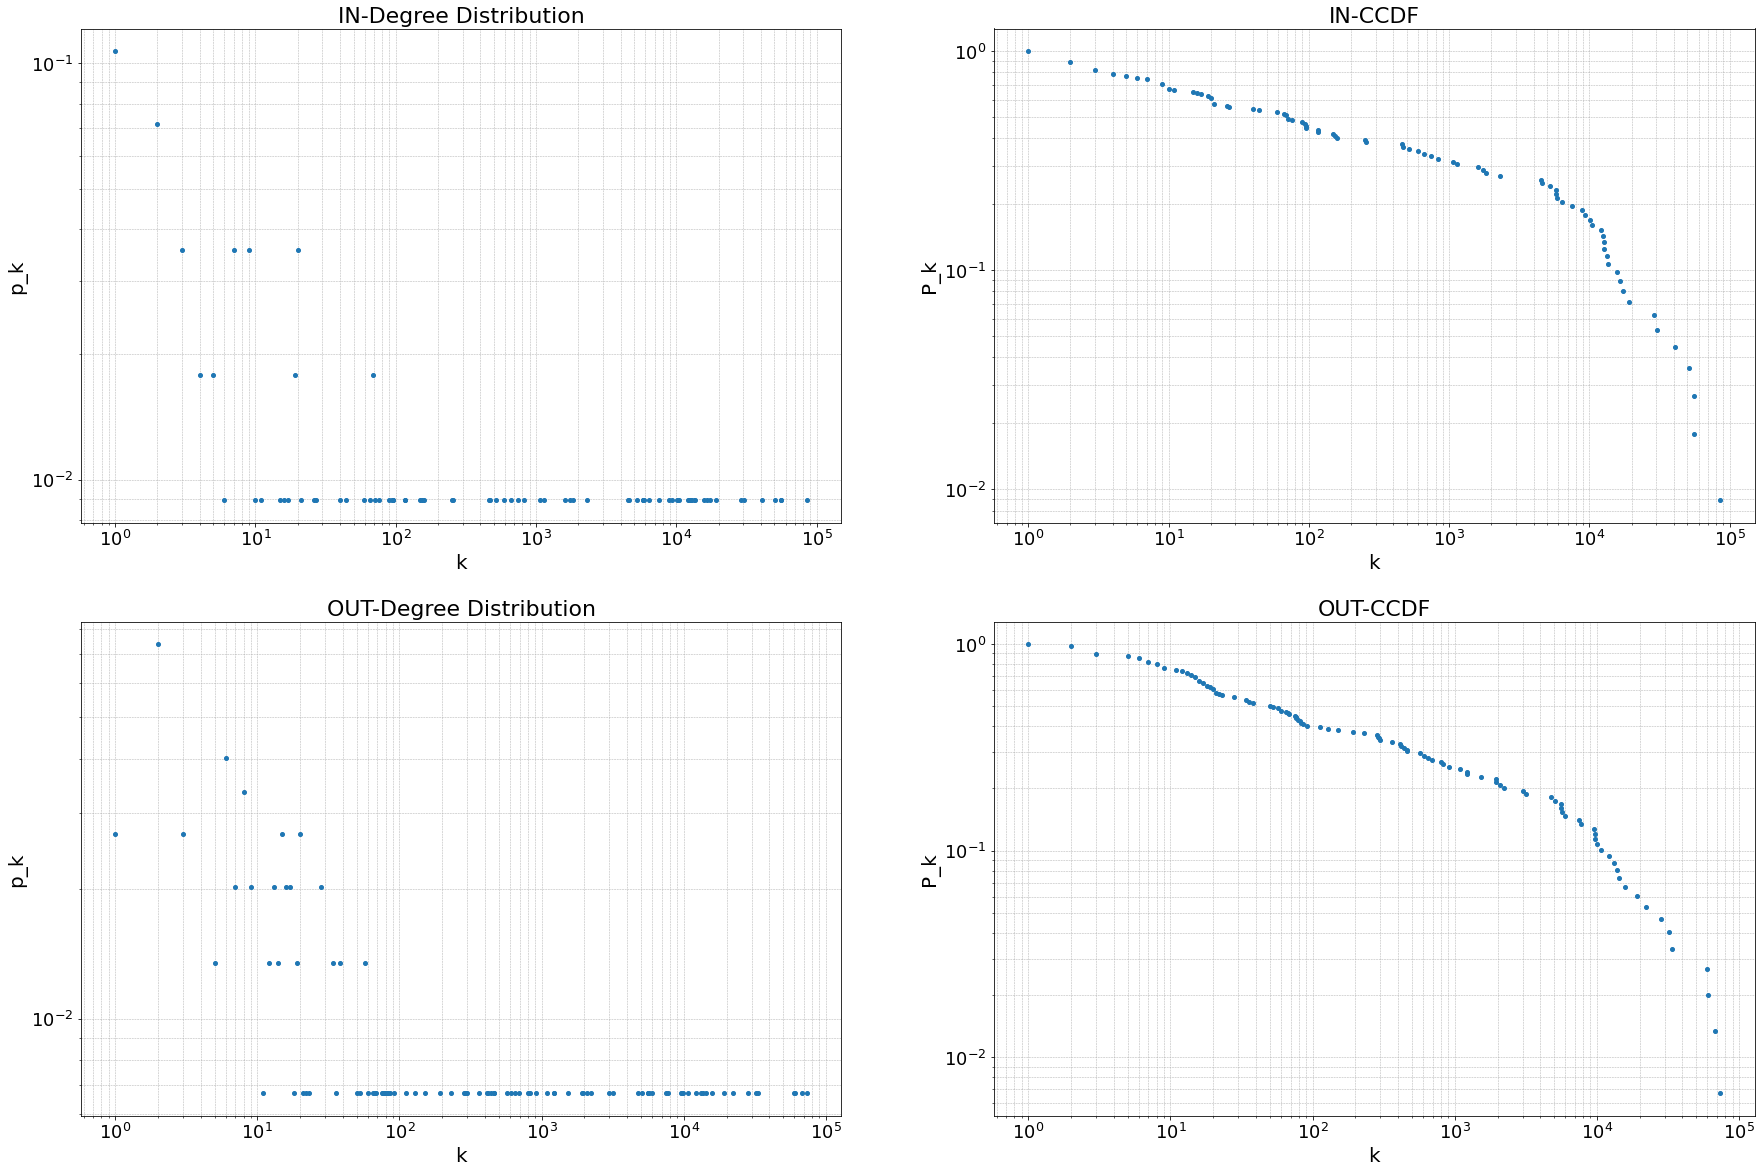

Top 10 for in degree


,Nodes,in degree
142,Spain,85255
108,UK,55556
120,Germany,55489
98,Italy,50912
48,France,40840
105,Poland,30154
103,Portugal,28984
133,Netherlands,19163
31,Ireland,17474
34,Czechia,16559


Top 10 for out degree


,Nodes,out degree
48,France,73481
120,Germany,67772
98,Italy,60222
142,Spain,59413
42,Turkey,33511
105,Poland,32388
108,UK,28448
133,Netherlands,22090
111,Romania,19294
103,Portugal,15750


In [6]:
scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
ns.display_top_n(scores, 10, 'in degree')
ns.display_top_n(scores, 10, 'out degree')

### HITS (NetworkX)

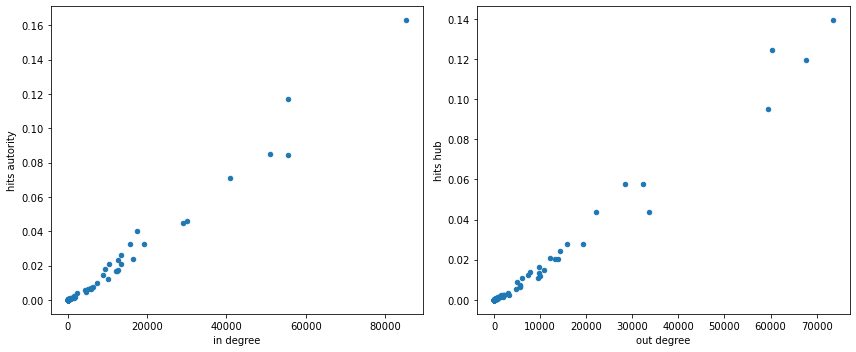

Top 10 for hits hub


,Nodes,hits hub
48,France,0.139283
98,Italy,0.124679
120,Germany,0.119749
142,Spain,0.094932
108,UK,0.057723
105,Poland,0.057705
133,Netherlands,0.043805
42,Turkey,0.043587
111,Romania,0.027973
103,Portugal,0.027626


Top 10 for hits autority


,Nodes,hits autority
142,Spain,0.162843
108,UK,0.117227
98,Italy,0.085113
120,Germany,0.084523
48,France,0.071154
105,Poland,0.046151
103,Portugal,0.044684
31,Ireland,0.040060
35,Belgium,0.032396
133,Netherlands,0.032326


In [7]:
df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'hits hub')
ns.display_top_n(scores, 10, 'hits autority')

### PageRank (NetworkX)

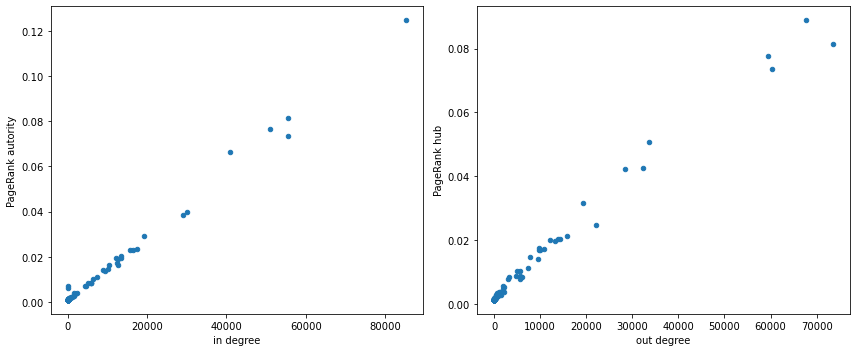

Top 10 for PageRank hub


,Nodes,PageRank hub
120,Germany,0.088870
48,France,0.081390
142,Spain,0.077764
98,Italy,0.073692
42,Turkey,0.050792
105,Poland,0.042699
108,UK,0.042150
111,Romania,0.031626
133,Netherlands,0.024640
103,Portugal,0.021385


Top 10 for PageRank autority


,Nodes,PageRank autority
142,Spain,0.124574
120,Germany,0.081602
98,Italy,0.076687
108,UK,0.073659
48,France,0.066544
105,Poland,0.040025
103,Portugal,0.038717
133,Netherlands,0.029240
31,Ireland,0.023405
34,Czechia,0.023160


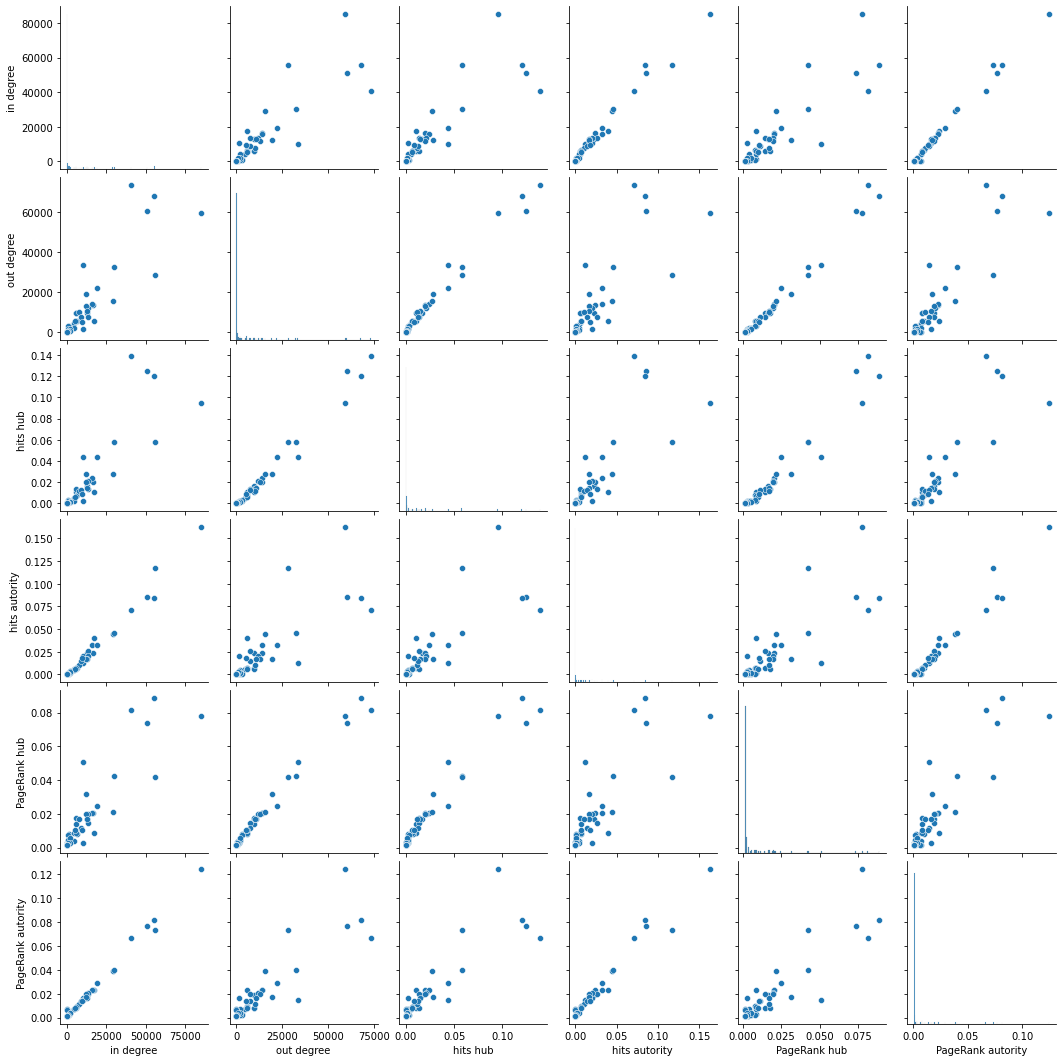

In [8]:
df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'PageRank hub')
ns.display_top_n(scores, 10, 'PageRank autority')

sns.pairplot(scores)
plt.show()

In [9]:
def create_position(score_df, label):
    scores = score_df.sort_values(label, ascending=False)
    scores[label+' position']= (np.arange(len(scores.index))+1)
    return scores

scores = create_position(scores, 'in degree')
scores = create_position(scores, 'out degree')
scores = create_position(scores, 'hits hub')
scores = create_position(scores, 'hits autority')
scores = create_position(scores, 'PageRank hub')
scores = create_position(scores, 'PageRank autority')
scores.sort_index(inplace=True)

In [10]:
n = 40
pd.set_option('display.max_rows', n)
display(scores.sort_values('PageRank autority', ascending=False)[['Nodes', 'in degree', 'in degree position', 'hits autority', 'hits autority position', 'PageRank autority', 'PageRank autority position']].head(n))
display(scores.sort_values('PageRank hub', ascending=False)[['Nodes', 'out degree', 'out degree position', 'hits hub', 'hits hub position', 'PageRank hub', 'PageRank hub position']].head(n))

,Nodes,in degree,in degree position,hits autority,hits autority position,PageRank autority,PageRank autority position
142,Spain,85255,1,0.162843,1,0.124574,1
120,Germany,55489,3,0.084523,4,0.081602,2
98,Italy,50912,4,0.085113,3,0.076687,3
108,UK,55556,2,0.117227,2,0.073659,4
48,France,40840,5,0.071154,5,0.066544,5
105,Poland,30154,6,0.046151,6,0.040025,6
103,Portugal,28984,7,0.044684,7,0.038717,7
133,Netherlands,19163,8,0.032326,10,0.029240,8
31,Ireland,17474,9,0.040060,8,0.023405,9
34,Czechia,16559,10,0.023774,12,0.023160,10


,Nodes,out degree,out degree position,hits hub,hits hub position,PageRank hub,PageRank hub position
120,Germany,67772,2,0.119749,3,0.088870,1
48,France,73481,1,0.139283,1,0.081390,2
142,Spain,59413,4,0.094932,4,0.077764,3
98,Italy,60222,3,0.124679,2,0.073692,4
42,Turkey,33511,5,0.043587,8,0.050792,5
105,Poland,32388,6,0.057705,6,0.042699,6
108,UK,28448,7,0.057723,5,0.042150,7
111,Romania,19294,9,0.027973,9,0.031626,8
133,Netherlands,22090,8,0.043805,7,0.024640,9
103,Portugal,15750,10,0.027626,10,0.021385,10


### Assortativity
We have to check if this disassortativity is due to structural reason, because it looks weird. It is almost the opposit of what we saw for the complete network.

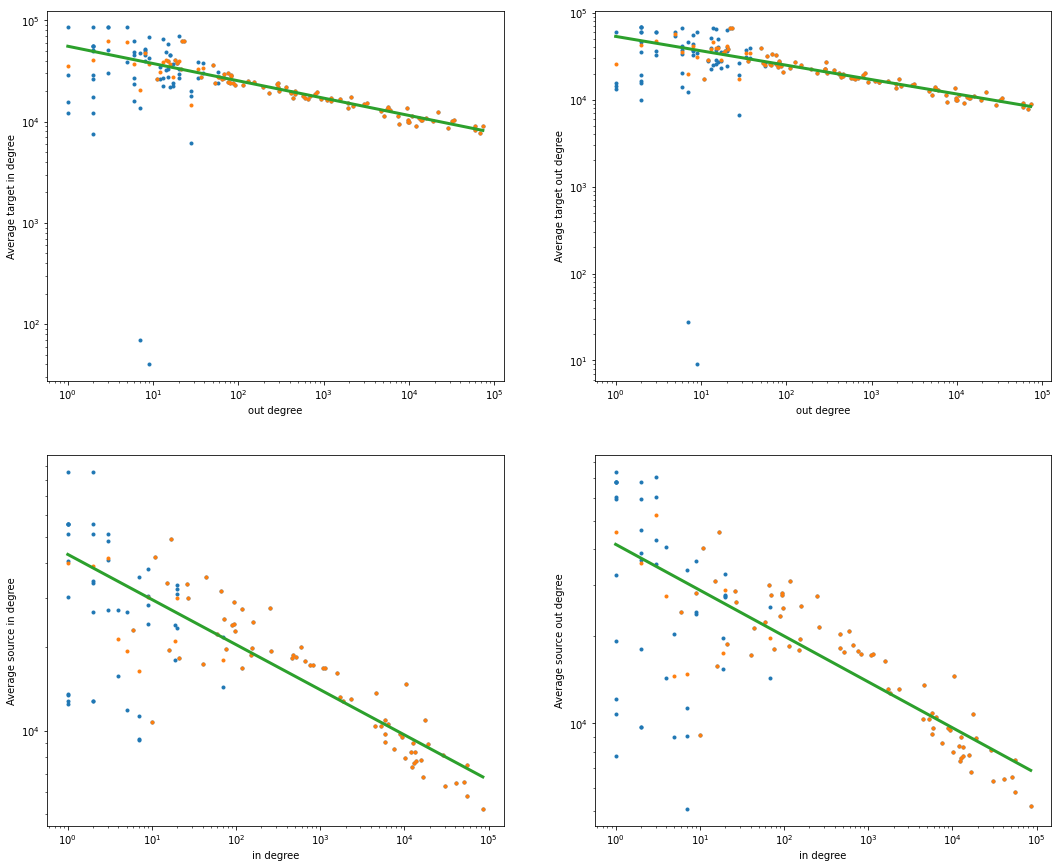

(-0.1709131474314809,
 -0.16566416781192514,
 -0.16258008251223896,
 -0.15802291954725187)

In [11]:
edges = country_df[['source','target']].copy()
ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True)

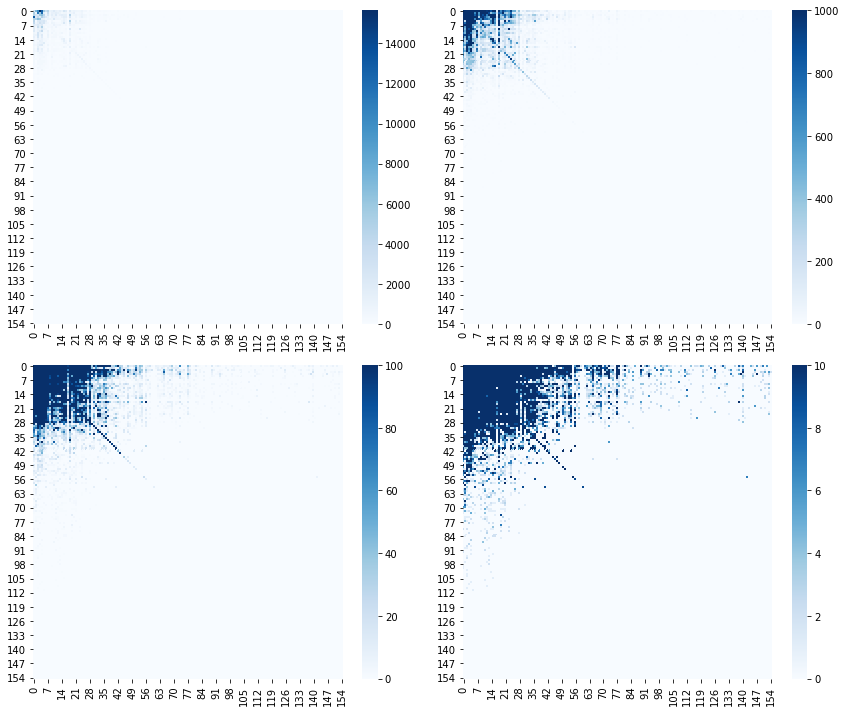

In [12]:
# label = 'PageRank autority position'
label = 'in degree position'
c = country_df.drop(['SendId', 'RecId'],axis=1)
another_order = scores[['Nodes', label]].copy()
another_order[label] = another_order[label] - 1
another_order.rename({'Nodes':'source', label: 'source ID'}, axis=1, inplace=True)
c = pd.merge(c, another_order, on="source")
another_order.rename({'source':'target', 'source ID': 'target ID'}, axis=1, inplace=True)
c = pd.merge(c, another_order, on="target")
c_serie = c.groupby(['source ID', 'target ID']).sum()
row = np.array(c_serie.index.get_level_values(1).tolist())
col = np.array(c_serie.index.get_level_values(0).tolist())
val = c_serie.values
or_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

ns.visualize_adj(or_adj)

The plot highlights differences between the adjacency matrix and the transpose one. It can explain disassortativity.

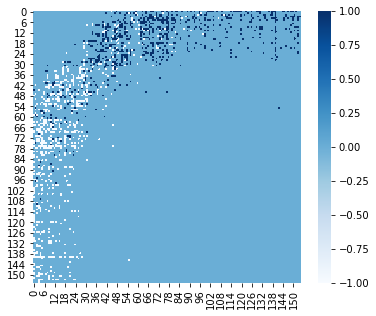

In [13]:
matr = or_adj.toarray()
matr[matr>1]=1
matr = matr - matr.T
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(matr, cmap="Blues", ax=ax)
plt.show()

This is only a draft version of community detection

In [14]:
import networkx as nx
# import community

G = nx.convert_matrix.from_scipy_sparse_matrix(adj_matrix_crs)
p = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)
node_comm = nodes_df.copy()

node_comm['Community']=np.zeros(len(node_comm.index),dtype='int8')
for i, set in enumerate(p):
    for element in set:
        node_comm.iat[element, 1]=i
for i, set in enumerate(p):
    display(node_comm[node_comm['Community']==i])


,Nodes,Community
0,North Macedonia,0
1,Slovakia,0
2,Ghana,0
3,"Palestine, State of",0
4,Botswana,0
...,...,...
150,South Georgia and the South Sandwich Islands,0
151,Papua New Guinea,0
152,Uganda,0
153,Mozambique,0


## Geographic Heat map 

<AxesSubplot:>

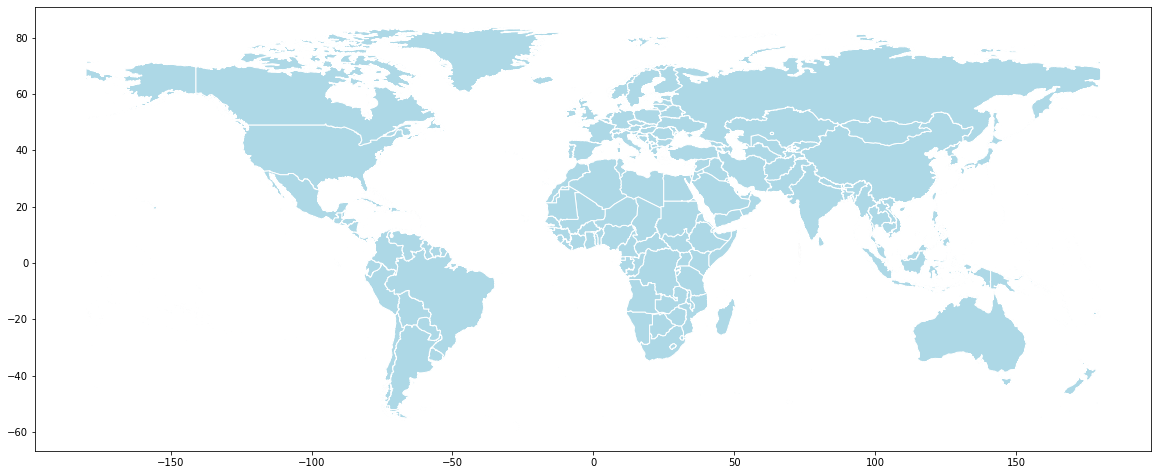

In [23]:
import geopandas as gpd

# Setting the path to the shapefile
shapefile = 'ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp'

# Read shapefile using Geopandas
geo_df = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]

# Rename columns
geo_df.columns = ['country', 'country_code', 'geometry']
geo_df.head(3)

# Drop row for 'Antarctica'. It takes a lot of space in the map and is not of much use
geo_df = geo_df.drop(geo_df.loc[geo_df['country'] == 'Antarctica'].index)

# Print the map
geo_df.plot(figsize=(20, 20), edgecolor='white', linewidth=1, color='lightblue')

Dhekelia Sovereign Base Area not found in regex
US Naval Base Guantanamo Bay not found in regex
Siachen Glacier not found in regex
Baykonur Cosmodrome not found in regex
Akrotiri Sovereign Base Area not found in regex
Southern Patagonian Ice Field not found in regex
Bir Tawil not found in regex
CuraÃ§ao not found in regex
SÃ£o TomÃ© and Principe not found in regex
Indian Ocean Territories not found in regex
Coral Sea Islands not found in regex
Spratly Islands not found in regex
Clipperton Island not found in regex
Ashmore and Cartier Islands not found in regex
Bajo Nuevo Bank (Petrel Is.) not found in regex
Serranilla Bank not found in regex
Scarborough Reef not found in regex
C:\Users\tomma\AppData\Local\Temp/ipykernel_4196/3888343567.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_df['iso2_c

(-197.99999999999991, 198.0, -66.62809417064994, 90.78944326365007)

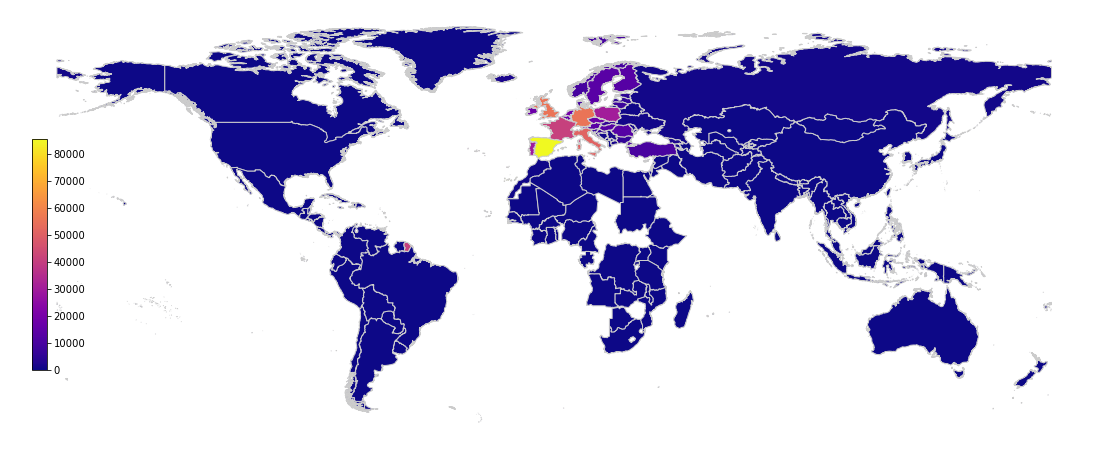

In [24]:
import country_converter as coco

fig, ax = plt.subplots(1, figsize=(20, 8))

# adding code country to scores dataframe
countries_codes = nodes_df
countries_codes['code'] = nodes
scores_merge = pd.merge(left=countries_codes, right=scores, how='right', left_on='Nodes', right_on='Nodes')

# geo_df contains iso3 codes so we need to convert them to iso2
geo_df['iso2_code'] = coco.convert(names=list(geo_df['country']), to='ISO2', not_found='NULL')
geo_df = geo_df.drop(geo_df.loc[geo_df['iso2_code'] == 'NULL'].index)

# in geo_df United Kingdom has code GB, so we have to change it manually
geo_df['iso2_code'][geo_df['country'] == 'United Kingdom'] = 'UK'

merged_df = pd.merge(left=geo_df, right=scores_merge, how='right', left_on='iso2_code', right_on='code')
merged_df.dropna(subset=['Nodes'], inplace=True)
merged_df.plot(column='in degree', ax=ax, edgecolor='0.8', linewidth=1, cmap='plasma')

sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=merged_df['in degree'].min(), 
                                              vmax=merged_df['in degree'].max()), cmap='plasma')

# Empty array for the data range
sm._A = []

# Add the colorbar to the figure
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)
ax.axis('off')

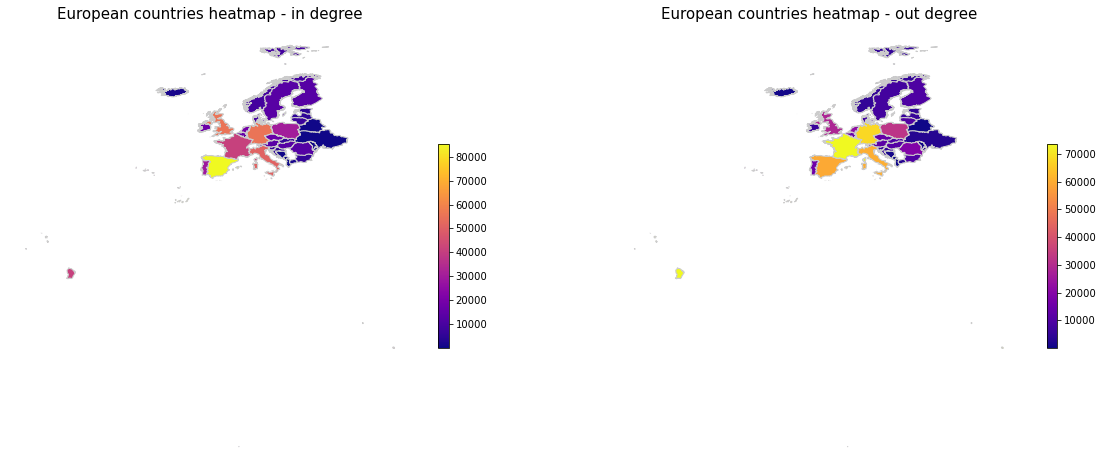

In [25]:
european_countries = ['Germany', 'United Kingdom', 'France', 'Italy', 'Spain', 'Ukraine', 'Poland', 'Romania', 
                'Netherlands', 'Belgium', 'Czechia', 'Greece', 'Portugal', 'Sweden', 'Hungary', 
                'Belarus', 'Austria', 'Serbia', 'Switzerland', 'Bulgaria', 'Denmark', 'Finland', 'Slovakia', 'Norway',
                'Ireland', 'Croatia', 'Moldova', 'Bosnia and Herzegovina', 'Albania', 'Lithuania', 'North Macedonia', 
                'Slovenia', 'Latvia', 'Estonia', 'Montenegro', 'Luxembourg', 'Malta', 'Iceland', 'Andorra', 'Monaco', 
                'Liechtenstein', 'San Marino', 'Holy See']

# Russia has not been taken in consideration since it was too big to show and has very low exchanges

european_df = merged_df[merged_df['country'].isin(european_countries)]

deg_list = ['in degree', 'out degree']
fig4, ax4 = plt.subplots(1, 2, figsize=(20,15))


for i in range(len(deg_list)):
    european_df.plot(column=deg_list[i], ax=ax4[i], edgecolor='0.8', linewidth=1, cmap='plasma')
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=european_df[deg_list[i]].min(), 
                                              vmax=european_df[deg_list[i]].max()), cmap='plasma')
    ax4[i].axis('off')
    fig4.colorbar(sm, ax=ax4[i], shrink=0.25)
    ax4[i].set_title('European countries heatmap - ' + deg_list[i], fontsize=15)